In [55]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import statistics 
from PIL import Image
import glob

In [56]:
class Dataset():
    def __init__(self,path,batch_size):
        self.batch_size = batch_size
        self.get_data(path)
        self.reset()
    
    def reset(self):
        self.start = 0
        self.end = self.start + self.batch_size
        np.random.shuffle(self.files)
        
    def get_label(self, path):
        return tf.convert_to_tensor(np.array(path.strip().split('/')[-1].split('_')[0], dtype = np.int32))
    
    def get_image(self, path):
        return tf.convert_to_tensor(np.mean(np.array(Image.open(path)), axis = 2).reshape((80,80,1)), dtype=tf.float32)
    
    def get_data(self, path):
        self.files = np.array([f for f in glob.glob(path + '/*.jpg')])
        self.dataset_size = len(self.files)
        np.random.shuffle(self.files)
        
    def get_next_batch(self):
        if self.dataset_size <= self.start:
            self.reset()
            return None, None
        readings = self.files[self.start:self.end]

        imgs, labels = [], []
        for f in readings:
            imgs.append(self.get_image(f))
            labels.append(self.get_label(f))
        imgs = tf.stack(imgs, axis=0)
        labels = tf.stack(labels, axis=0)
        self.start = self.end
        self.end = self.start + self.batch_size
        if self.dataset_size <= self.end:
            self.end = self.dataset_size
        return imgs, labels

In [57]:
def conv2d(input, weight, bias, stride_size, pad = 'SAME', batchnorm = False):
    out = tf.nn.conv2d(input, weight, strides=[1, stride_size, stride_size, 1], padding=pad)
    out = tf.nn.bias_add(out,bias)
    
    if batchnorm == True:
        mean, var = tf.nn.moments(out, axes=[0,1,2], keepdims=False)
        out = tf.nn.batch_normalization(out, mean, var, offset = 0, scale = 1, variance_epsilon = 0.00001)
    
    return tf.nn.relu(out)

def maxpool(input, pool_size, stride_size, pad = 'VALID'):
    return tf.nn.max_pool2d(input, ksize=[1, pool_size, pool_size, 1], padding=pad, strides=[1, stride_size, stride_size, 1])

def dense(input, weight, bias, dropout_rate):
    x = tf.matmul(input, weight)
    x = tf.nn.bias_add(x, bias)
    
    if dropout_rate != 0:
        x = tf.nn.dropout(x, rate=dropout_rate)
        
    x = tf.nn.relu(x)
    return x

In [58]:
# Model specific functions, edit as you wish
def get_model_parameters(weight_shapes, bias_shapes, initializer_type = 'random'):
    def get_weight(shape, name, initializer):
        return tf.Variable(initializer(shape), name=name, trainable=True, dtype=tf.float32)
    
    if initializer_type == 'xavier':
        initializer = tf.initializers.glorot_uniform()
    else:
        initializer = tf.random_normal_initializer()

    weights = []
    for i in range(len(weight_shapes)):
        weights.append(get_weight(weight_shapes[i], 'weight{}'.format(i), initializer))
        
    biases = []
    for i in range(len(bias_shapes)):
        biases.append(get_weight(bias_shapes[i], 'bias{}'.format(i), initializer))
    return weights, biases

def get_loss(model, input, labels, weights, biases, dropout_rate, weight_decay):
    out = tf.reshape(model(input, weights, biases, dropout_rate), [-1])
    # loss = 0         
    # for weight in weights:
    #     loss += tf.reduce_mean(tf.nn.l2_loss(weight)) * weight_decay
    loss = tf.math.reduce_mean(tf.math.abs(tf.cast(labels, dtype = tf.float32) - out))
    # loss = tf.keras.losses.MAE(labels, out)
    return loss

def train_step(model, optimizer, input, labels, weights, biases, dropout_rate, weight_decay):    
    with tf.GradientTape() as tape:
        loss = get_loss(model, input, labels, weights, biases, dropout_rate, weight_decay)
    dw, db = tape.gradient(loss, [weights, biases])
    optimizer.apply_gradients(zip(dw, weights))
    optimizer.apply_gradients(zip(db, biases))

def train_model(model, weights, biases, train_ds, val_ds, optimizer, learning_rate = 0.0005, num_epochs = 20, dropout_rate = 0.5, weight_decay = 0.00001):
    val_losses = []
    for e in range(num_epochs):
        idx = 1
        #print('training: batch', end = ' ')
        while True:
            x,y = train_ds.get_next_batch()

            if x != None:
                #print('{}'.format(idx), end = ' ')
                train_step(model, optimizer, x, y, weights, biases, dropout_rate, weight_decay)
                #idx += 1
            else:
                break            
        val_losses = []
        while True:
            x,y = val_ds.get_next_batch()

            if x != None:
                out = model(x, weights, biases, dropout_rate)
                val_losses.append(tf.reduce_mean(tf.keras.losses.mae(y, out)).numpy())
                # print('{} -> {}'.format(y, out))
            else:
                break
        print('\nepoch {} - val_loss: {:.3f}'.format(e + 1, statistics.mean(val_losses)))

In [26]:
train_ds = Dataset('data/training/',1)
val_ds = Dataset('data/validation/',1)                                        


epoch 1 - val_loss1: 1.281, val_loss2: 1.289

epoch 2 - val_loss1: 1.282, val_loss2: 1.202

epoch 3 - val_loss1: 1.154, val_loss2: 1.095

epoch 4 - val_loss1: 1.109, val_loss2: 1.084

epoch 5 - val_loss1: 1.081, val_loss2: 1.085

epoch 6 - val_loss1: 1.153, val_loss2: 1.071

epoch 7 - val_loss1: 1.067, val_loss2: 1.021

epoch 8 - val_loss1: 1.051, val_loss2: 1.045

epoch 9 - val_loss1: 1.038, val_loss2: 1.064

epoch 10 - val_loss1: 1.021, val_loss2: 1.047


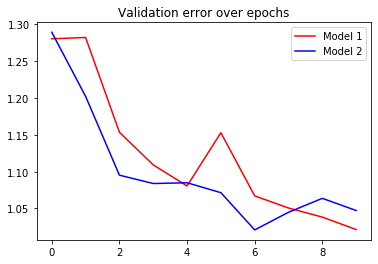

In [29]:
# Initialization                                   
def model_bnT(x, weights, biases, dropout_rate): # batchnorm = True
    y = conv2d(x, weights[0], biases[0], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[1], biases[1], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[2], biases[2], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[3], biases[3], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = tf.reshape(y, shape=(tf.shape(y)[0], -1))
    y = dense(y, weights[4], biases[4], dropout_rate = dropout_rate)
    y = dense(y, weights[5], biases[5], dropout_rate = dropout_rate)
    y = tf.matmul(y, weights[6]) + biases[6]
    return y

def train_2models(model1, weights1, biases1, model2, weights2, biases2, train_ds, val_ds, optimizer1, optimizer2, \
    lr1 = 0.0005, lr2 = 0.0005, num_epochs = 20, dropout_rate1 = 0.5, dropout_rate2 = 0.5, weight_decay1 = 0.00001, weight_decay2 = 0.00001):
    cross_epoch_losses1 = []
    cross_epoch_losses2 = []
    for e in range(num_epochs):
        idx = 1
        #print('training: batch', end = ' ')
        while True:
            x,y = train_ds.get_next_batch()

            if x != None:
                #print('{}'.format(idx), end = ' ')
                train_step(model1, optimizer1, x, y, weights1, biases1, dropout_rate1, weight_decay1)
                train_step(model2, optimizer2, x, y, weights2, biases2, dropout_rate2, weight_decay2)
                #idx += 1
            else:
                break            
        val_losses1 = []
        val_losses2 = []
        while True:
            x,y = val_ds.get_next_batch()

            if x != None:
                out = model1(x, weights1, biases1, dropout_rate1)
                val_losses1.append(tf.reduce_mean(tf.keras.losses.mae(y, out)).numpy())

                out = model2(x, weights2, biases2, dropout_rate2)
                val_losses2.append(tf.reduce_mean(tf.keras.losses.mae(y, out)).numpy())
                # print('{} -> {}'.format(y, out))
            else:
                break
        
        crl1 = statistics.mean(val_losses1)
        crl2 = statistics.mean(val_losses2)
        cross_epoch_losses1.append(crl1)
        cross_epoch_losses2.append(crl2)
        print('\nepoch {} - val_loss1: {:.3f}, val_loss2: {:.3f}'.format(e + 1, crl1, crl2))
    plt.figure()
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses1, 'r-', label='Model 1')
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses2, 'b-', label='Model 2')
    plt.legend()
    plt.title('Validation error over epochs')
    plt.show()

num_epochs = 10
lr = 0.00002
optimizer1 = tf.keras.optimizers.SGD(lr, 0.95)
weights1, biases1 = get_model_parameters([
    [3, 3, 1, 8],
    [3, 3, 8, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [8,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

optimizer2 = tf.keras.optimizers.SGD(lr, 0.95)
weights2, biases2 = get_model_parameters([
    [3, 3, 1, 8],
    [3, 3, 8, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [8,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
], 'xavier')

train_2models(model_bnT, weights1, biases1, model_bnT, weights2, biases2, train_ds, val_ds, optimizer1, optimizer2, \
    lr, lr, num_epochs, 0, 0, 0, 0)


epoch 1 - val_loss1: 1.275, val_loss2: 1.327

epoch 2 - val_loss1: 1.138, val_loss2: 1.241

epoch 3 - val_loss1: 1.103, val_loss2: 1.203

epoch 4 - val_loss1: 1.089, val_loss2: 1.574

epoch 5 - val_loss1: 1.041, val_loss2: 1.132

epoch 6 - val_loss1: 1.037, val_loss2: 1.145

epoch 7 - val_loss1: 1.036, val_loss2: 1.136

epoch 8 - val_loss1: 1.020, val_loss2: 1.126

epoch 9 - val_loss1: 0.995, val_loss2: 1.265

epoch 10 - val_loss1: 1.029, val_loss2: 1.141


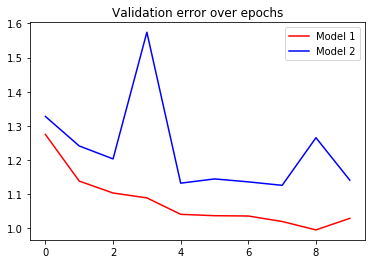

In [30]:
# Batchnorm

def model_bnF(x, weights, biases, dropout_rate): # batchnorm = False
    y = conv2d(x, weights[0], biases[0], stride_size=1, batchnorm = False)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[1], biases[1], stride_size=1, batchnorm = False)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[2], biases[2], stride_size=1, batchnorm = False)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[3], biases[3], stride_size=1, batchnorm = False)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = tf.reshape(y, shape=(tf.shape(y)[0], -1))
    y = dense(y, weights[4], biases[4], dropout_rate = dropout_rate)
    y = dense(y, weights[5], biases[5], dropout_rate = dropout_rate)
    y = tf.matmul(y, weights[6]) + biases[6]
    return y

def model_bnT(x, weights, biases, dropout_rate): # batchnorm = True
    y = conv2d(x, weights[0], biases[0], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[1], biases[1], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[2], biases[2], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[3], biases[3], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = tf.reshape(y, shape=(tf.shape(y)[0], -1))
    y = dense(y, weights[4], biases[4], dropout_rate = dropout_rate)
    y = dense(y, weights[5], biases[5], dropout_rate = dropout_rate)
    y = tf.matmul(y, weights[6]) + biases[6]
    return y

num_epochs = 10
lr = 0.00002
optimizer1 = tf.keras.optimizers.SGD(lr, 0.95)
weights1, biases1 = get_model_parameters([
    [3, 3, 1, 8],
    [3, 3, 8, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [8,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

optimizer2 = tf.keras.optimizers.SGD(lr, 0.95)
weights2, biases2 = get_model_parameters([
    [3, 3, 1, 8],
    [3, 3, 8, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [8,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

train_2models(model_bnT, weights1, biases1, model_bnF, weights2, biases2, train_ds, val_ds, optimizer1, optimizer2, \
    lr, lr, num_epochs, 0, 0, 0, 0)


epoch 1 - val_loss1: 1.619, val_loss2: 1.463, val_loss3: 1.322, val_loss4: 1.216

epoch 2 - val_loss1: 1.529, val_loss2: 1.316, val_loss3: 1.250, val_loss4: 1.136

epoch 3 - val_loss1: 1.452, val_loss2: 1.274, val_loss3: 1.207, val_loss4: 1.071

epoch 4 - val_loss1: 1.381, val_loss2: 1.218, val_loss3: 1.157, val_loss4: 1.046

epoch 5 - val_loss1: 1.324, val_loss2: 1.181, val_loss3: 1.140, val_loss4: 1.027

epoch 6 - val_loss1: 1.282, val_loss2: 1.150, val_loss3: 1.133, val_loss4: 1.099

epoch 7 - val_loss1: 1.250, val_loss2: 1.132, val_loss3: 1.154, val_loss4: 1.011

epoch 8 - val_loss1: 1.230, val_loss2: 1.112, val_loss3: 1.112, val_loss4: 1.062

epoch 9 - val_loss1: 1.214, val_loss2: 1.099, val_loss3: 1.123, val_loss4: 0.991

epoch 10 - val_loss1: 1.202, val_loss2: 1.082, val_loss3: 1.104, val_loss4: 1.001

epoch 11 - val_loss1: 1.199, val_loss2: 1.081, val_loss3: 1.084, val_loss4: 1.020

epoch 12 - val_loss1: 1.187, val_loss2: 1.054, val_loss3: 1.082, val_loss4: 0.996

epoch 13 - v

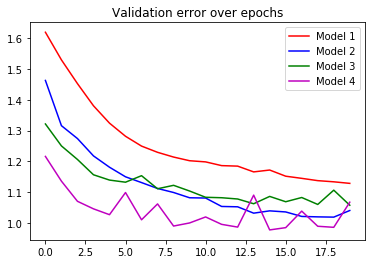

In [59]:
# Optimizer
def train_4models(model1, weights1, biases1, model2, weights2, biases2, model3, weights3, biases3, model4, weights4, biases4, train_ds, val_ds, \
    optimizer1, optimizer2, optimizer3, optimizer4, lr1, lr2, lr3, lr4, num_epochs, dr1, dr2, dr3, dr4, wd1, wd2, wd3, wd4):
    # dr: dropout
    # wd: weight decay
    cross_epoch_losses1 = []
    cross_epoch_losses2 = []
    cross_epoch_losses3 = []
    cross_epoch_losses4 = []
    for e in range(num_epochs):
        idx = 1
        #print('training: batch', end = ' ')
        while True:
            x,y = train_ds.get_next_batch()

            if x != None:
                #print('{}'.format(idx), end = ' ')
                train_step(model1, optimizer1, x, y, weights1, biases1, dr1, wd1)
                train_step(model2, optimizer2, x, y, weights2, biases2, dr2, wd2)
                train_step(model3, optimizer3, x, y, weights3, biases3, dr3, wd3)
                train_step(model4, optimizer4, x, y, weights4, biases4, dr4, wd4)
                #idx += 1
            else:
                break            
        val_losses1 = []
        val_losses2 = []
        val_losses3 = []
        val_losses4 = []
        while True:
            x,y = val_ds.get_next_batch()

            if x != None:
                out = model1(x, weights1, biases1, dr1)
                val_losses1.append(tf.math.reduce_mean(tf.math.abs(tf.cast(y, dtype = tf.float32) - out)).numpy())

                out = model2(x, weights2, biases2, dr2)
                val_losses2.append(tf.math.reduce_mean(tf.math.abs(tf.cast(y, dtype = tf.float32) - out)).numpy())
                
                out = model3(x, weights3, biases3, dr3)
                val_losses3.append(tf.math.reduce_mean(tf.math.abs(tf.cast(y, dtype = tf.float32) - out)).numpy())
                
                out = model4(x, weights4, biases4, dr4)
                val_losses4.append(tf.math.reduce_mean(tf.math.abs(tf.cast(y, dtype = tf.float32) - out)).numpy())
                # print('{} -> {}'.format(y, out))
            else:
                break
        
        crl1 = statistics.mean(val_losses1)
        crl2 = statistics.mean(val_losses2)
        crl3 = statistics.mean(val_losses3)
        crl4 = statistics.mean(val_losses4)
        cross_epoch_losses1.append(crl1)
        cross_epoch_losses2.append(crl2)
        cross_epoch_losses3.append(crl3)
        cross_epoch_losses4.append(crl4)
        print('\nepoch {} - val_loss1: {:.3f}, val_loss2: {:.3f}, val_loss3: {:.3f}, val_loss4: {:.3f}'.format(e + 1, crl1, crl2, crl3, crl4))
    plt.figure()
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses1, 'r-', label='Model 1')
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses2, 'b-', label='Model 2')
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses3, 'g-', label='Model 3')
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses4, 'm-', label='Model 4')
    plt.legend()
    plt.title('Validation error over epochs')
    plt.show()


def model_bnT(x, weights, biases, dropout_rate): # batchnorm = True
    y = conv2d(x, weights[0], biases[0], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[1], biases[1], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[2], biases[2], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[3], biases[3], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = tf.reshape(y, shape=(tf.shape(y)[0], -1))
    y = dense(y, weights[4], biases[4], dropout_rate = dropout_rate)
    y = dense(y, weights[5], biases[5], dropout_rate = dropout_rate)
    y = tf.matmul(y, weights[6]) + biases[6]
    return y

num_epochs = 20
lr1 = 0.00001
optimizer1 = tf.keras.optimizers.Adam(lr1)
weights1, biases1 = get_model_parameters([
    [3, 3, 1, 8],
    [3, 3, 8, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [8,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

lr2 = 0.000025
optimizer2 = tf.keras.optimizers.Adam(lr2)
weights2, biases2 = get_model_parameters([
    [3, 3, 1, 8],
    [3, 3, 8, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [8,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

lr3 = 0.00005
optimizer3 = tf.keras.optimizers.Adam(lr3)
weights3, biases3 = get_model_parameters([
    [3, 3, 1, 8],
    [3, 3, 8, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [8,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

lr4 = 0.0001
optimizer4 = tf.keras.optimizers.Adam(lr4)
weights4, biases4 = get_model_parameters([
    [3, 3, 1, 8],
    [3, 3, 8, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [8,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

train_4models(model_bnT, weights1, biases1, model_bnT, weights2, biases2, model_bnT, weights3, biases3, model_bnT, weights4, biases4, train_ds, val_ds, \
    optimizer1, optimizer2, optimizer3, optimizer4, lr1, lr2, lr3, lr4, num_epochs, 0, 0, 0, 0, 0, 0, 0, 0)


epoch 1 - val_loss1: 1.537, val_loss2: 1.349, val_loss3: 1.474, val_loss4: 1.498

epoch 2 - val_loss1: 1.436, val_loss2: 1.236, val_loss3: 1.288, val_loss4: 1.372

epoch 3 - val_loss1: 1.367, val_loss2: 1.211, val_loss3: 1.196, val_loss4: 1.299

epoch 4 - val_loss1: 1.313, val_loss2: 1.185, val_loss3: 1.140, val_loss4: 1.256

epoch 5 - val_loss1: 1.280, val_loss2: 1.190, val_loss3: 1.115, val_loss4: 1.242

epoch 6 - val_loss1: 1.252, val_loss2: 1.168, val_loss3: 1.092, val_loss4: 1.217

epoch 7 - val_loss1: 1.234, val_loss2: 1.158, val_loss3: 1.077, val_loss4: 1.200

epoch 8 - val_loss1: 1.225, val_loss2: 1.152, val_loss3: 1.067, val_loss4: 1.195

epoch 9 - val_loss1: 1.204, val_loss2: 1.185, val_loss3: 1.065, val_loss4: 1.190

epoch 10 - val_loss1: 1.205, val_loss2: 1.131, val_loss3: 1.042, val_loss4: 1.170


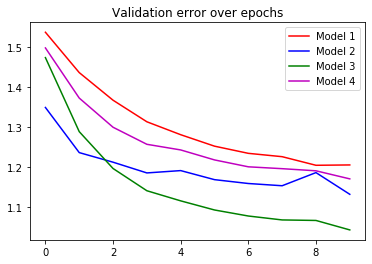

In [60]:
# Model architecture
def model1(x, weights, biases, dropout_rate): # batchnorm = True
    y = conv2d(x, weights[0], biases[0], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[1], biases[1], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[2], biases[2], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[3], biases[3], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = tf.reshape(y, shape=(tf.shape(y)[0], -1))
    y = dense(y, weights[4], biases[4], dropout_rate = dropout_rate)
    y = dense(y, weights[5], biases[5], dropout_rate = dropout_rate)
    y = tf.matmul(y, weights[6]) + biases[6]
    return y

def model2(x, weights, biases, dropout_rate): # batchnorm = True
    y = conv2d(x, weights[0], biases[0], stride_size=1, batchnorm = True)
    y = conv2d(y, weights[1], biases[1], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[2], biases[2], stride_size=1, batchnorm = True)
    y = conv2d(y, weights[3], biases[3], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[4], biases[4], stride_size=1, batchnorm = True)
    y = conv2d(y, weights[5], biases[5], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[6], biases[6], stride_size=1, batchnorm = True)
    y = conv2d(y, weights[7], biases[7], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = tf.reshape(y, shape=(tf.shape(y)[0], -1))
    y = dense(y, weights[8], biases[8], dropout_rate = dropout_rate)
    y = dense(y, weights[9], biases[9], dropout_rate = dropout_rate)
    y = tf.matmul(y, weights[10]) + biases[10]
    return y

def model3(x, weights, biases, dropout_rate): # batchnorm = True
    y = conv2d(x, weights[0], biases[0], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[1], biases[1], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[2], biases[2], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[3], biases[3], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)
    
    y = conv2d(y, weights[4], biases[4], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = tf.reshape(y, shape=(tf.shape(y)[0], -1))
    y = dense(y, weights[5], biases[5], dropout_rate = dropout_rate)
    y = dense(y, weights[6], biases[6], dropout_rate = dropout_rate)
    y = tf.matmul(y, weights[7]) + biases[7]
    return y

num_epochs = 10
lr = 0.00002
optimizer1 = tf.keras.optimizers.Adam(lr)
weights1, biases1 = get_model_parameters([
    [3, 3, 1, 2],
    [3, 3, 2, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [2,],
    [4,],
    [8,],
    [16,],
    [64,],
    [8,],
    [1,],
])

optimizer2 = tf.keras.optimizers.Adam(lr)
weights2, biases2 = get_model_parameters([
    [3, 3, 1, 2],
    [3, 3, 2, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],  
    [3, 3, 16, 32],
    [3, 3, 32, 32], 
    [800, 128],
    [128, 16], 
    [16, 1],
], [
    [2,],
    [4,],
    [8,],
    [8,],
    [16,],
    [16,],
    [32,],
    [32,],
    [128,],
    [16,],
    [1,],
])

optimizer3 = tf.keras.optimizers.Adam(lr)
weights3, biases3 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 16],
    [3, 3, 16, 16],
    [3, 3, 16, 64],
    [3, 3, 64, 64],
    [256, 32],
    [32, 4], 
    [4, 1],
], [
    [4,],
    [16,],
    [16,],
    [64,],
    [64,],
    [32,],
    [4,],
    [1,],
])

optimizer4 = tf.keras.optimizers.Adam(lr)
weights4, biases4 = get_model_parameters([
    [3, 3, 1, 2],
    [3, 3, 2, 2],
    
    [3, 3, 2, 4],
    [3, 3, 4, 4],
    
    [3, 3, 4, 8],
    [3, 3, 8, 8],
    
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [2,],
    [2,],
    [4,],
    [4,],
    [8,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

train_4models(model1, weights1, biases1, model2, weights2, biases2, model3, weights3, biases3, model2, weights4, biases4, train_ds, val_ds, \
    optimizer1, optimizer2, optimizer3, optimizer4, lr, lr, lr, lr, num_epochs, 0, 0, 0, 0, 0, 0, 0, 0)


epoch 1 - val_loss1: 1.470, val_loss2: 1.453, val_loss3: 1.507, val_loss4: 1.450

epoch 2 - val_loss1: 1.327, val_loss2: 1.318, val_loss3: 1.384, val_loss4: 1.306

epoch 3 - val_loss1: 1.250, val_loss2: 1.260, val_loss3: 1.272, val_loss4: 1.234

epoch 4 - val_loss1: 1.210, val_loss2: 1.215, val_loss3: 1.225, val_loss4: 1.173

epoch 5 - val_loss1: 1.209, val_loss2: 1.212, val_loss3: 1.238, val_loss4: 1.170

epoch 6 - val_loss1: 1.162, val_loss2: 1.163, val_loss3: 1.172, val_loss4: 1.127

epoch 7 - val_loss1: 1.149, val_loss2: 1.147, val_loss3: 1.154, val_loss4: 1.107

epoch 8 - val_loss1: 1.132, val_loss2: 1.125, val_loss3: 1.142, val_loss4: 1.096

epoch 9 - val_loss1: 1.143, val_loss2: 1.144, val_loss3: 1.150, val_loss4: 1.088

epoch 10 - val_loss1: 1.124, val_loss2: 1.112, val_loss3: 1.129, val_loss4: 1.064


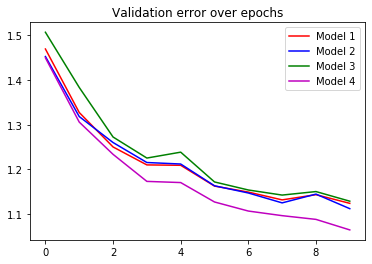

In [61]:
# Loss functions
def loss_mae(model, input, labels, weights, biases, dropout_rate, weight_decay):
    out = model(input, weights, biases, dropout_rate)
    loss = tf.math.reduce_mean(tf.math.abs(tf.cast(labels, dtype = tf.float32) - out))
    return loss
    
def loss_mse(model, input, labels, weights, biases, dropout_rate, weight_decay):
    out = model(input, weights, biases, dropout_rate)
    loss = tf.math.reduce_mean(tf.math.square(tf.cast(labels, dtype = tf.float32) - out))
    return loss

def loss_mse_mae(model, input, labels, weights, biases, dropout_rate, weight_decay):
    out = model(input, weights, biases, dropout_rate)
    mse = tf.math.reduce_mean(tf.math.square(tf.cast(labels, dtype = tf.float32) - out))
    mae = tf.math.reduce_mean(tf.math.abs(tf.cast(labels, dtype = tf.float32) - out))
    loss = mse + mae # mse + mae
    return loss

def loss_max_mse_mae(model, input, labels, weights, biases, dropout_rate, weight_decay):
    out = model(input, weights, biases, dropout_rate)
    mse = tf.math.reduce_mean(tf.math.square(tf.cast(labels, dtype = tf.float32) - out))
    mae = tf.math.reduce_mean(tf.math.abs(tf.cast(labels, dtype = tf.float32) - out))
    loss = tf.math.maximum(mae, mse)
    return loss

def loss_min_mse_mae(model, input, labels, weights, biases, dropout_rate, weight_decay):
    out = model(input, weights, biases, dropout_rate)
    mse = tf.math.reduce_mean(tf.math.square(tf.cast(labels, dtype = tf.float32) - out))
    mae = tf.math.reduce_mean(tf.math.abs(tf.cast(labels, dtype = tf.float32) - out))
    loss = tf.math.minimum(mae, mse)
    return loss

def train_step_withloss(model, loss, optimizer, input, labels, weights, biases, dropout_rate, weight_decay):    
    with tf.GradientTape() as tape:
        current_loss = loss(model, input, labels, weights, biases, dropout_rate, weight_decay)
    dw, db = tape.gradient(current_loss, [weights, biases])
    optimizer.apply_gradients(zip(dw, weights))
    optimizer.apply_gradients(zip(db, biases))


def train_4models_withloss(model1, weights1, biases1, loss1, model2, weights2, biases2, loss2, model3, weights3, biases3, loss3, model4, weights4, biases4, loss4, train_ds, val_ds, \
    optimizer1, optimizer2, optimizer3, optimizer4, lr1, lr2, lr3, lr4, num_epochs, dr1, dr2, dr3, dr4, wd1, wd2, wd3, wd4):
    # dr: dropout
    # wd: weight decay
    cross_epoch_losses1 = []
    cross_epoch_losses2 = []
    cross_epoch_losses3 = []
    cross_epoch_losses4 = []
    for e in range(num_epochs):
        idx = 1
        #print('training: batch', end = ' ')
        while True:
            x,y = train_ds.get_next_batch()

            if x != None:
                #print('{}'.format(idx), end = ' ')
                train_step_withloss(model1, loss1, optimizer1, x, y, weights1, biases1, dr1, wd1)
                train_step_withloss(model2, loss2, optimizer2, x, y, weights2, biases2, dr2, wd2)
                train_step_withloss(model3, loss3, optimizer3, x, y, weights3, biases3, dr3, wd3)
                train_step_withloss(model4, loss4, optimizer4, x, y, weights4, biases4, dr4, wd4)
                #idx += 1
            else:
                break            
        val_losses1 = []
        val_losses2 = []
        val_losses3 = []
        val_losses4 = []
        while True:
            x,y = val_ds.get_next_batch()

            if x != None:
                val_losses1.append(loss_mae(model1, x, y, weights1, biases1, dr1, wd1).numpy())
                val_losses2.append(loss_mae(model2, x, y, weights2, biases2, dr2, wd2).numpy())
                val_losses3.append(loss_mae(model3, x, y, weights3, biases3, dr3, wd3).numpy())
                val_losses4.append(loss_mae(model4, x, y, weights4, biases4, dr4, wd4).numpy())
            else:
                break
        
        crl1 = statistics.mean(val_losses1)
        crl2 = statistics.mean(val_losses2)
        crl3 = statistics.mean(val_losses3)
        crl4 = statistics.mean(val_losses4)
        cross_epoch_losses1.append(crl1)
        cross_epoch_losses2.append(crl2)
        cross_epoch_losses3.append(crl3)
        cross_epoch_losses4.append(crl4)
        print('\nepoch {} - val_loss1: {:.3f}, val_loss2: {:.3f}, val_loss3: {:.3f}, val_loss4: {:.3f}'.format(e + 1, crl1, crl2, crl3, crl4))
    plt.figure()
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses1, 'r-', label='Model 1')
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses2, 'b-', label='Model 2')
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses3, 'g-', label='Model 3')
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses4, 'm-', label='Model 4')
    plt.legend()
    plt.title('Validation error over epochs')
    plt.show()

def model(x, weights, biases, dropout_rate):
    y = conv2d(x, weights[0], biases[0], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[1], biases[1], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[2], biases[2], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[3], biases[3], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = tf.reshape(y, shape=(tf.shape(y)[0], -1))
    y = dense(y, weights[4], biases[4], dropout_rate = dropout_rate)
    y = dense(y, weights[5], biases[5], dropout_rate = dropout_rate)
    y = tf.matmul(y, weights[6]) + biases[6]
    return y

num_epochs = 10
lr = 0.000025
optimizer1 = tf.keras.optimizers.Adam(lr)
weights1, biases1 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

optimizer2 = tf.keras.optimizers.Adam(lr)
weights2, biases2 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

optimizer3 = tf.keras.optimizers.Adam(lr)
weights3, biases3 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

optimizer4 = tf.keras.optimizers.Adam(lr)
weights4, biases4 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

train_4models_withloss(model, weights1, biases1, loss_mse, model, weights2, biases2, loss_mse_mae, model, weights3, biases3, loss_max_mse_mae, \
    model, weights4, biases4, loss_min_mse_mae, train_ds, val_ds, optimizer1, optimizer2, optimizer3, optimizer4, lr, lr, lr, lr, num_epochs, 0, 0, 0, 0, 0, 0, 0, 0)


epoch 1 - val_loss1: 1.499, val_loss2: 1.446, val_loss3: 1.510, val_loss4: 1.462

epoch 2 - val_loss1: 1.382, val_loss2: 1.304, val_loss3: 1.367, val_loss4: 1.353

epoch 3 - val_loss1: 1.305, val_loss2: 1.234, val_loss3: 1.260, val_loss4: 1.288

epoch 4 - val_loss1: 1.284, val_loss2: 1.207, val_loss3: 1.214, val_loss4: 1.267

epoch 5 - val_loss1: 1.204, val_loss2: 1.172, val_loss3: 1.139, val_loss4: 1.219

epoch 6 - val_loss1: 1.173, val_loss2: 1.152, val_loss3: 1.118, val_loss4: 1.196

epoch 7 - val_loss1: 1.151, val_loss2: 1.131, val_loss3: 1.103, val_loss4: 1.185

epoch 8 - val_loss1: 1.123, val_loss2: 1.120, val_loss3: 1.114, val_loss4: 1.180

epoch 9 - val_loss1: 1.104, val_loss2: 1.116, val_loss3: 1.076, val_loss4: 1.160

epoch 10 - val_loss1: 1.098, val_loss2: 1.141, val_loss3: 1.086, val_loss4: 1.151


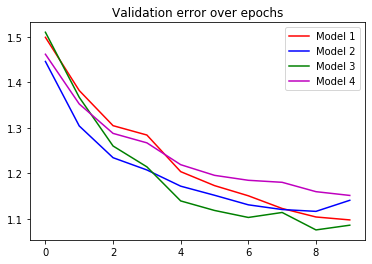

In [62]:
# L2 Norm
def loss_l2(model, input, labels, weights, biases, dr, wd):
    out = tf.reshape(model(input, weights, biases, dr), [-1])
    loss = 0         
    for weight in weights:
        loss += tf.reduce_mean(tf.nn.l2_loss(weight)) * wd
    loss += tf.math.reduce_mean(tf.math.abs(tf.cast(labels, dtype = tf.float32) - out))
    return loss

def model(x, weights, biases, dropout_rate):
    y = conv2d(x, weights[0], biases[0], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[1], biases[1], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[2], biases[2], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[3], biases[3], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = tf.reshape(y, shape=(tf.shape(y)[0], -1))
    y = dense(y, weights[4], biases[4], dropout_rate = dropout_rate)
    y = dense(y, weights[5], biases[5], dropout_rate = dropout_rate)
    y = tf.matmul(y, weights[6]) + biases[6]
    return y

num_epochs = 10
lr = 0.000025
optimizer1 = tf.keras.optimizers.Adam(lr)
weights1, biases1 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

optimizer2 = tf.keras.optimizers.Adam(lr)
weights2, biases2 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

optimizer3 = tf.keras.optimizers.Adam(lr)
weights3, biases3 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

optimizer4 = tf.keras.optimizers.Adam(lr)
weights4, biases4 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

train_4models_withloss(model, weights1, biases1, loss_l2, model, weights2, biases2, loss_l2, model, weights3, biases3, loss_l2, \
    model, weights4, biases4, loss_l2, train_ds, val_ds, optimizer1, optimizer2, optimizer3, optimizer4, lr, lr, lr, lr, num_epochs, 0, 0, 0, 0, 0.00001, 0.00005, 0.0001, 0.0005)


epoch 1 - val_loss1: 2.345, val_loss2: 2.014, val_loss3: 1.879, val_loss4: 1.820

epoch 2 - val_loss1: 2.248, val_loss2: 1.909, val_loss3: 1.687, val_loss4: 1.678

epoch 3 - val_loss1: 2.150, val_loss2: 1.789, val_loss3: 1.636, val_loss4: 1.589

epoch 4 - val_loss1: 2.068, val_loss2: 1.740, val_loss3: 1.594, val_loss4: 1.514

epoch 5 - val_loss1: 2.054, val_loss2: 1.738, val_loss3: 1.540, val_loss4: 1.462

epoch 6 - val_loss1: 2.015, val_loss2: 1.709, val_loss3: 1.505, val_loss4: 1.462

epoch 7 - val_loss1: 1.961, val_loss2: 1.679, val_loss3: 1.499, val_loss4: 1.420

epoch 8 - val_loss1: 1.964, val_loss2: 1.626, val_loss3: 1.477, val_loss4: 1.397

epoch 9 - val_loss1: 1.923, val_loss2: 1.573, val_loss3: 1.545, val_loss4: 1.393

epoch 10 - val_loss1: 1.784, val_loss2: 1.573, val_loss3: 1.449, val_loss4: 1.350


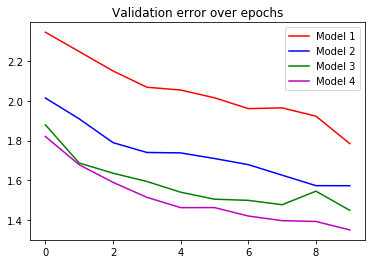

In [63]:
# Dropout
def model(x, weights, biases, dropout_rate):
    y = conv2d(x, weights[0], biases[0], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[1], biases[1], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[2], biases[2], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[3], biases[3], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = tf.reshape(y, shape=(tf.shape(y)[0], -1))
    y = dense(y, weights[4], biases[4], dropout_rate = dropout_rate)
    y = dense(y, weights[5], biases[5], dropout_rate = dropout_rate)
    y = tf.matmul(y, weights[6]) + biases[6]
    return y

num_epochs = 10
lr = 0.000025
optimizer1 = tf.keras.optimizers.Adam(lr)
weights1, biases1 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

optimizer2 = tf.keras.optimizers.Adam(lr)
weights2, biases2 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

optimizer3 = tf.keras.optimizers.Adam(lr)
weights3, biases3 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

optimizer4 = tf.keras.optimizers.Adam(lr)
weights4, biases4 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])

train_4models_withloss(model, weights1, biases1, loss_mae, model, weights2, biases2, loss_mae, model, weights3, biases3, loss_mae, \
    model, weights4, biases4, loss_mae, train_ds, val_ds, optimizer1, optimizer2, optimizer3, optimizer4, lr, lr, lr, lr, num_epochs, 0.5, 0.4, 0.3, 0.2, 0, 0, 0, 0)


epoch 1 - val_loss1: 1.483, val_loss2: 2.810, val_loss3: 3.975, val_loss4: 4.094

epoch 2 - val_loss1: 1.376, val_loss2: 1.664, val_loss3: 3.706, val_loss4: 4.043

epoch 3 - val_loss1: 1.305, val_loss2: 1.637, val_loss3: 3.299, val_loss4: 4.067

epoch 4 - val_loss1: 1.251, val_loss2: 1.633, val_loss3: 2.813, val_loss4: 4.056

epoch 5 - val_loss1: 1.203, val_loss2: 1.631, val_loss3: 2.278, val_loss4: 3.975

epoch 6 - val_loss1: 1.164, val_loss2: 1.629, val_loss3: 1.912, val_loss4: 3.961

epoch 7 - val_loss1: 1.135, val_loss2: 1.625, val_loss3: 1.687, val_loss4: 3.964

epoch 8 - val_loss1: 1.120, val_loss2: 1.629, val_loss3: 1.650, val_loss4: 3.919

epoch 9 - val_loss1: 1.102, val_loss2: 1.629, val_loss3: 1.641, val_loss4: 3.819

epoch 10 - val_loss1: 1.079, val_loss2: 1.626, val_loss3: 1.637, val_loss4: 3.810


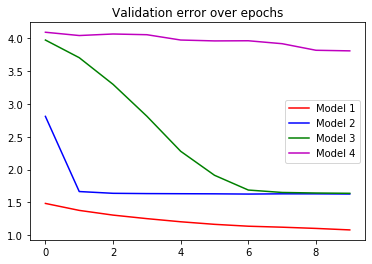

In [64]:
# Batchsize
def train_4models_withloss_withdatasets(model1, weights1, biases1, loss1, model2, weights2, biases2, loss2, model3, weights3, biases3, loss3, model4, weights4, biases4, loss4, \
    train_ds1, val_ds1, train_ds2, val_ds2, train_ds3, val_ds3, train_ds4, val_ds4,optimizer1, optimizer2, optimizer3, optimizer4, lr1, lr2, lr3, lr4, num_epochs, \
    dr1, dr2, dr3, dr4, wd1, wd2, wd3, wd4):
    cross_epoch_losses1 = []
    cross_epoch_losses2 = []
    cross_epoch_losses3 = []
    cross_epoch_losses4 = []
    for e in range(num_epochs):
        while True:
            x,y = train_ds1.get_next_batch()

            if x != None:
                train_step_withloss(model1, loss1, optimizer1, x, y, weights1, biases1, dr1, wd1)
            else:
                break
                
        while True:
            x,y = train_ds2.get_next_batch()

            if x != None:
                train_step_withloss(model2, loss2, optimizer2, x, y, weights2, biases2, dr2, wd2)
            else:
                break
        
        while True:
            x,y = train_ds3.get_next_batch()

            if x != None:
                train_step_withloss(model3, loss3, optimizer3, x, y, weights3, biases3, dr3, wd3)
            else:
                break
        
        while True:
            x,y = train_ds4.get_next_batch()

            if x != None:
                train_step_withloss(model4, loss4, optimizer4, x, y, weights4, biases4, dr4, wd4)
            else:
                break
                   
        val_losses1 = []
        val_losses2 = []
        val_losses3 = []
        val_losses4 = []
        
        while True:
            x,y = val_ds1.get_next_batch()

            if x != None:
                val_losses1.append(loss_mae(model1, x, y, weights1, biases1, dr1, wd1).numpy())
            else:
                break
                
        while True:
            x,y = val_ds2.get_next_batch()

            if x != None:
                val_losses2.append(loss_mae(model2, x, y, weights2, biases2, dr2, wd2).numpy())
            else:
                break
        
        while True:
            x,y = val_ds3.get_next_batch()

            if x != None:
                val_losses3.append(loss_mae(model3, x, y, weights3, biases3, dr3, wd3).numpy())
            else:
                break
        
        while True:
            x,y = val_ds4.get_next_batch()

            if x != None:
                val_losses4.append(loss_mae(model4, x, y, weights4, biases4, dr4, wd4).numpy())
            else:
                break
        
        crl1 = statistics.mean(val_losses1)
        crl2 = statistics.mean(val_losses2)
        crl3 = statistics.mean(val_losses3)
        crl4 = statistics.mean(val_losses4)
        cross_epoch_losses1.append(crl1)
        cross_epoch_losses2.append(crl2)
        cross_epoch_losses3.append(crl3)
        cross_epoch_losses4.append(crl4)
        print('\nepoch {} - val_loss1: {:.3f}, val_loss2: {:.3f}, val_loss3: {:.3f}, val_loss4: {:.3f}'.format(e + 1, crl1, crl2, crl3, crl4))
    plt.figure()
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses1, 'r-', label='Model 1')
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses2, 'b-', label='Model 2')
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses3, 'g-', label='Model 3')
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses4, 'm-', label='Model 4')
    plt.legend()
    plt.title('Validation error over epochs')
    plt.show()

# Batchsize
def model(x, weights, biases, dropout_rate):
    y = conv2d(x, weights[0], biases[0], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[1], biases[1], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[2], biases[2], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[3], biases[3], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = tf.reshape(y, shape=(tf.shape(y)[0], -1))
    y = dense(y, weights[4], biases[4], dropout_rate = dropout_rate)
    y = dense(y, weights[5], biases[5], dropout_rate = dropout_rate)
    y = tf.matmul(y, weights[6]) + biases[6]
    return y

num_epochs = 10
lr = 0.000025
optimizer1 = tf.keras.optimizers.Adam(lr)
weights1, biases1 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])
train_ds1 = Dataset('data/training/',1)
val_ds1 = Dataset('data/validation/',1)                                        


optimizer2 = tf.keras.optimizers.Adam(lr)
weights2, biases2 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])
train_ds2 = Dataset('data/training/',16)
val_ds2 = Dataset('data/validation/',16)                                        


optimizer3 = tf.keras.optimizers.Adam(lr)
weights3, biases3 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])
train_ds3 = Dataset('data/training/',64)
val_ds3 = Dataset('data/validation/',64)    

optimizer4 = tf.keras.optimizers.Adam(lr)
weights4, biases4 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 8],
    [3, 3, 8, 16],
    [3, 3, 16, 16],
    [400, 64],
    [64, 8], 
    [8, 1],
], [
    [4,],
    [8,],
    [16,],
    [16,],
    [64,],
    [8,],
    [1,],
])
train_ds4 = Dataset('data/training/',256)
val_ds4 = Dataset('data/validation/',256) 

train_4models_withloss_withdatasets(model, weights1, biases1, loss_mae, model, weights2, biases2, loss_mae, model, weights3, biases3, loss_mae, \
    model, weights4, biases4, loss_mae, train_ds1, val_ds1, train_ds2, val_ds2, train_ds3, val_ds3, train_ds4, val_ds4, optimizer1, optimizer2, \
    optimizer3, optimizer4, lr, lr, lr, lr, num_epochs, 0, 0, 0, 0, 0, 0, 0, 0)